<h1>Capstone Project</h1>
<h2>Explore and cluster the neighborhoods in Jakarta</h2>

In [2]:
# data analsysis
import pandas as pd 
# HTTP library
import requests 
# convert an address into latitude and longitude values 
from geopy.geocoders import Nominatim 
# map chart
import folium
# data in a vectorized manner manipulation
import numpy as np 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# tranform JSON file
#from pandas.io.json import json_normalize 
# JSON files manipulation
#import json 
# scraping library
#from bs4 import BeautifulSoup 
# sklearn clustering algorithm
#from sklearn.cluster import KMeans 

print('Libraries imported.')

Libraries imported.


In [229]:
df_raw = pd.read_csv('data/jakarta-join-oke.csv')
df_raw.drop(df_raw[['Unnamed: 0']], axis=1, inplace=True)

print('The jakarta dataframe shape is', df_raw.shape)
df_raw.head()

The jakarta dataframe shape is (267, 8)


,urban,sub_district,city,province_code,postal_code,address,latitude,longitude
0,ANCOL,PADEMANGAN,JAKARTA UTARA,31,14430,"ANCOL, ID 14430",-6.1264,106.8291
1,ANGKE,TAMBORA,JAKARTA BARAT,31,11330,"ANGKE, ID 11330",-6.1459,106.7959
2,BALEKAMBANG,KRAMAT JATI,JAKARTA TIMUR,31,13530,"BALEKAMBANG, ID 13530",-6.2814,106.8524
3,BANGKA,MAMPANG PRAPATAN,JAKARTA SELATAN,31,12730,"BANGKA, ID 12730",-6.2654,106.8186
4,BARU,PASAR REBO,JAKARTA TIMUR,31,13780,"BARU, ID 13780",-6.3241,106.8466


In [231]:
print('The jakarta dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_raw['sub_district'].unique()),
        df_raw.shape[0]
    )
)

The jakarta dataframe has 44 boroughs and 267 neighborhoods.


In [6]:
latitude_jakarta = -6.2658393
longitude_jakarta = 106.7842567
df_jakarta = df_raw

map_jakarta = folium.Map(location=[latitude_jakarta, longitude_jakarta], zoom_start=11)
# add markers to map
for lat, lng, urban, sub_district in zip(
    df_jakarta['latitude'], 
    df_jakarta['longitude'], 
    df_jakarta['urban'], 
    df_jakarta['sub_district']):
    label = '{}, {}'.format(sub_district, urban)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  
    
map_jakarta

The map shows that the Postal codes are not evenly spaced, and the area cover by some of them, using a radius of 500 meters, overlaps. A different radius for each postcode results in a better venues search because that will avoid misrepresentation of the number of venues per postcode caused by too large or low radius values.

Next thing to do is explore each Postcode to get venues using the Foursquare API.

In [7]:
# Foursquare ID
CLIENT_ID = 'RT3CZHJPAA3QVQLSBQMWDKUFWSE44IK5KPUS3CJLUVJ4ZZ0B'
# Foursquare Secret
CLIENT_SECRET = 'KRAUWAKS1FJCWQC0K5U4JPWTMXAUTF4QOGRHSPL3NLUCUPE0'
VERSION = '20181102'

In [8]:
# defining radius and limit of venues
radius = 500
LIMIT = 100

# function
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}' \
            '&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'urban', 
        'urban latitude', 
        'urban Longitude', 
        'Venue', 
        'Venue Latitude', 
        'Venue Longitude', 
        'Venue Category']
    return(nearby_venues)

In [67]:
print(df_jakarta.shape)
df_jakarta_tmp = df_jakarta.loc[241:270, :]
df_jakarta_tmp.head()

(267, 8)


,urban,sub_district,city,province_code,postal_code,address,latitude,longitude
241,RAWA JATI,PANCORAN,JAKARTA SELATAN,31,12750,"RAWA JATI, ID 12750",-6.258448,106.854713
242,RAWA TERATE,CAKUNG,JAKARTA TIMUR,31,13920,"RAWA TERATE, ID 13920",-6.186047,106.921104
243,ROA MALAKA,TAMBORA,JAKARTA BARAT,31,11230,"ROA MALAKA, ID 11230",-6.137322,106.810463
244,SEMANAN,KALIDERES,JAKARTA BARAT,31,11850,"SEMANAN, ID 11850",-6.164927,106.705773
245,SEMPER TIMUR,CILINCING,JAKARTA UTARA,31,14130,"SEMPER TIMUR, ID 14130",-6.127098,106.929958


In [68]:
jakarta_venues = getNearbyVenues(
    names = df_jakarta_tmp['urban'],
    latitudes = df_jakarta_tmp['latitude'],
    longitudes = df_jakarta_tmp['longitude']
)

RAWA JATI
https://api.foursquare.com/v2/venues/explore?&client_id=XJUHBGRJCFHGNSGRBI4IHMQBFJPZJFTN0R3OSZHWBS2YSULR&client_secret=E2NWSN5U5E024C5HIQAFJGERV2TQLNUU45Z0D3X2ARHQ1PAX&v=20181102&ll=-6.2584475999999984,106.85471329999999&radius=500&limit=100
RAWA TERATE
https://api.foursquare.com/v2/venues/explore?&client_id=XJUHBGRJCFHGNSGRBI4IHMQBFJPZJFTN0R3OSZHWBS2YSULR&client_secret=E2NWSN5U5E024C5HIQAFJGERV2TQLNUU45Z0D3X2ARHQ1PAX&v=20181102&ll=-6.1860472,106.92110430000001&radius=500&limit=100
ROA MALAKA
https://api.foursquare.com/v2/venues/explore?&client_id=XJUHBGRJCFHGNSGRBI4IHMQBFJPZJFTN0R3OSZHWBS2YSULR&client_secret=E2NWSN5U5E024C5HIQAFJGERV2TQLNUU45Z0D3X2ARHQ1PAX&v=20181102&ll=-6.1373225,106.8104633&radius=500&limit=100
SEMANAN
https://api.foursquare.com/v2/venues/explore?&client_id=XJUHBGRJCFHGNSGRBI4IHMQBFJPZJFTN0R3OSZHWBS2YSULR&client_secret=E2NWSN5U5E024C5HIQAFJGERV2TQLNUU45Z0D3X2ARHQ1PAX&v=20181102&ll=-6.164927099999999,106.7057733&radius=500&limit=100
SEMPER TIMUR
https://api

In [69]:
jakarta_venues.shape
jakarta_venues.tail()

,urban,urban latitude,urban Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
240,WIJAYA KUSUMA,-6.154903,106.779494,Rumah Makan Bu Broto,-6.157012,106.777679,Food Court
241,WIJAYA KUSUMA,-6.154903,106.779494,Kwetiau Kasih,-6.152869,106.783234,Chinese Restaurant
242,WIJAYA KUSUMA,-6.154903,106.779494,ASOKA ARENA,-6.155115,106.775905,Basketball Court
243,WIJAYA KUSUMA,-6.154903,106.779494,Zen Salon,-6.152834,106.783121,Salon / Barbershop
244,WIJAYA KUSUMA,-6.154903,106.779494,Nasi Bebek Cendrawasih,-6.151165,106.777342,Asian Restaurant


In [72]:
jakarta_venues_9 = jakarta_venues
jakarta_venues_9.shape
jakarta_venues_9.to_csv('data/jakarta-venues-9.csv')

load venues from files

In [234]:
df_raw = pd.read_csv('data/jakarta-venues.csv', encoding = "ISO-8859-1")  
df_raw.drop(['Unnamed: 0'], axis=1, inplace=True)

print('the venues dataframe shape is', df_raw .shape)
df_raw.head()

the venues dataframe shape is (3635, 7)


,urban,urban latitude,urban Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ANCOL,-6.1264,106.8291,Discovery Hotel & Convention Ancol,-6.126035,106.831260,Hotel
1,ANCOL,-6.1264,106.8291,Dunia Fantasi (DUFAN),-6.124300,106.832089,Theme Park
2,ANCOL,-6.1264,106.8291,Talaga Sampireun,-6.126231,106.833339,Sundanese Restaurant
3,ANCOL,-6.1264,106.8291,Aston Marina,-6.129624,106.829485,Hotel
4,ANCOL,-6.1264,106.8291,Jaya Ancol Bowling Centre,-6.128302,106.831782,Bowling Alley


In [235]:
jakarta_venues = df_raw
print('jakarta venues dataframe shape is', jakarta_venues.shape)
print('There are {} uniques categories.'.format(len(jakarta_venues['Venue Category'].unique())))
jakarta_venues.head()

jakarta venues dataframe shape is (3635, 7)
There are 270 uniques categories.


,urban,urban latitude,urban Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ANCOL,-6.1264,106.8291,Discovery Hotel & Convention Ancol,-6.126035,106.831260,Hotel
1,ANCOL,-6.1264,106.8291,Dunia Fantasi (DUFAN),-6.124300,106.832089,Theme Park
2,ANCOL,-6.1264,106.8291,Talaga Sampireun,-6.126231,106.833339,Sundanese Restaurant
3,ANCOL,-6.1264,106.8291,Aston Marina,-6.129624,106.829485,Hotel
4,ANCOL,-6.1264,106.8291,Jaya Ancol Bowling Centre,-6.128302,106.831782,Bowling Alley


Analyze Each Neighborhood

In [204]:
# one hot encoding
jakarta_onehot = pd.get_dummies(jakarta_venues[['Venue Category']], prefix="", prefix_sep="")
jakarta_onehot.head()

,Accessories Store,Acehnese Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
# add urban column back to dataframe
jakarta_onehot['urban'] = jakarta_venues['urban'] 

# move urban column to the first column
fixed_columns = [jakarta_onehot.columns[-1]] + list(jakarta_onehot.columns[:-1])
jakarta_onehot = jakarta_onehot[fixed_columns]

print('jakarta onehot dataframe shape is', jakarta_onehot.shape)
jakarta_onehot.head()

jakarta onehot dataframe shape is (3635, 271)


,urban,Accessories Store,Acehnese Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store
0,ANCOL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ANCOL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ANCOL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ANCOL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ANCOL,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [211]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
import scipy.spatial.distance

# scale 
scaler = preprocessing.MinMaxScaler()
jakarta_onehot_kmeans = jakarta_onehot.loc[:, "Accessories Store":"Women's Store"]
scaler.fit(jakarta_onehot_kmeans)
jakarta_onehot_transformed = scaler.transform(jakarta_onehot_kmeans)
#jakarta_onehot_transformed

# initialize k
distortions = []
inertias = []
K = range(1,15)
X = jakarta_onehot_transformed
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(scipy.spatial.distance.cdist(X, kmeanModel.cluster_centers_,'euclidean'),axis=1))/X.shape[0]) 
    inertias.append(kmeanModel.inertia_)

print('proses complete.')

proses complete.


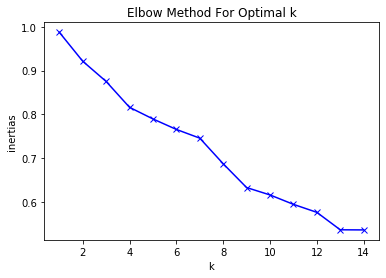

In [213]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('inertias')
#plt.ylabel('distortions')
plt.title('Elbow Method For Optimal k')

plt.show()

group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [248]:
jakarta_grouped = jakarta_onehot.groupby('urban').mean().reset_index()
jakarta_grouped['Total'] = np.count_nonzero(jakarta_grouped, axis=1)

print('jakarta grouped dataframe shape is', jakarta_grouped.shape)
jakarta_grouped.head()

jakarta grouped dataframe shape is (259, 272)


,urban,Accessories Store,Acehnese Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Vape Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Total
0,ANCOL,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14
1,ANGKE,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
2,BALEKAMBANG,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,BALI MESTER,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.038462,...,0.0,0.038462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20
4,BAMBU APUS,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


each neighborhood along with the top 5 most common venues

In [119]:
num_top_venues = 5

for hood in jakarta_grouped['urban']:
    print("----"+hood+"----")
    temp = jakarta_grouped[jakarta_grouped['urban'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANCOL----
                          venue  freq
0                    Theme Park  0.16
1  Theme Park Ride / Attraction  0.16
2                         Hotel  0.12
3               Harbor / Marina  0.08
4            Seafood Restaurant  0.08


----ANGKE----
                   venue  freq
0           Noodle House  0.25
1  Indonesian Restaurant  0.12
2                 Lounge  0.12
3            Snack Place  0.12
4              Juice Bar  0.12


----BALEKAMBANG----
                     venue  freq
0     Fast Food Restaurant  0.25
1               Restaurant  0.25
2               Food Court  0.25
3                      Gym  0.25
4  New American Restaurant  0.00


----BALI MESTER----
                   venue  freq
0       Asian Restaurant  0.12
1          Jewelry Store  0.12
2      Convenience Store  0.08
3  Indonesian Restaurant  0.08
4     Chinese Restaurant  0.08


----BAMBU APUS----
                   venue  freq
0  Indonesian Restaurant  0.50
1             Soup Place  0.25
2     Seafood 

                       venue  freq
0                 Food Truck  0.25
1               Noodle House  0.25
2  Indonesian Meatball Place  0.25
3                      River  0.25
4                Music Venue  0.00


----DUREN TIGA----
              venue  freq
0            Market  0.14
1  Sushi Restaurant  0.14
2         Bookstore  0.14
3       Karaoke Bar  0.14
4       Coffee Shop  0.14


----DURI KEPA----
               venue  freq
0         Restaurant  0.25
1        Coffee Shop  0.25
2         Food Truck  0.25
3       Soccer Field  0.25
4  Accessories Store  0.00


----DURI KOSAMBI----
                           venue  freq
0               Asian Restaurant  0.14
1  Vegetarian / Vegan Restaurant  0.14
2                    High School  0.14
3                   Noodle House  0.14
4                           Café  0.14


----DURI PULO----
                  venue  freq
0         Movie Theater  0.08
1         Shopping Mall  0.08
2            Food Court  0.08
3  Fast Food Restaurant  0.08
4  G

               venue  freq
0                Spa  0.33
1  Convenience Store  0.33
2     Breakfast Spot  0.33
3          Multiplex  0.00
4             Museum  0.00


----KAPUK----
               venue  freq
0  Convenience Store   1.0
1  Accessories Store   0.0
2       Neighborhood   0.0
3             Office   0.0
4       Nudist Beach   0.0


----KAPUK MUARA----
           venue  freq
0    Coffee Shop  0.50
1    Pizza Place  0.25
2  Boat or Ferry  0.25
3   Neighborhood  0.00
4   Nudist Beach  0.00


----KARANG ANYAR----
                   venue  freq
0       Asian Restaurant  0.19
1              BBQ Joint  0.12
2  Indonesian Restaurant  0.12
3            Karaoke Bar  0.12
4      Convenience Store  0.12


----KARET----
                 venue  freq
0                 Café  0.12
1   Chinese Restaurant  0.09
2           Steakhouse  0.06
3  Japanese Restaurant  0.06
4             Wine Bar  0.06


----KARET KUNINGAN----
                   venue  freq
0                  Hotel  0.14
1           No

                venue  freq
0  Chinese Restaurant  0.14
1    Department Store  0.14
2       Movie Theater  0.14
3            Hospital  0.14
4         Karaoke Bar  0.14


----KRAMAT PELA----
                   venue  freq
0            Coffee Shop  0.12
1    Japanese Restaurant  0.07
2  Indonesian Restaurant  0.07
3             Steakhouse  0.05
4                   Café  0.05


----KRENDANG----
                venue  freq
0  Chinese Restaurant  0.36
1    Asian Restaurant  0.14
2   Convenience Store  0.14
3      Breakfast Spot  0.07
4          Food Court  0.07


----KRUKUT----
                   venue  freq
0     Chinese Restaurant  0.28
1           Noodle House  0.16
2       Asian Restaurant  0.09
3      Convenience Store  0.06
4  Indonesian Restaurant  0.06


----KUNINGAN BARAT----
         venue  freq
0  Coffee Shop  0.18
1   Food Court  0.09
2        Hotel  0.09
3       Office  0.06
4   Food Truck  0.06


----KUNINGAN TIMUR----
              venue  freq
0       Coffee Shop  0.11
1  Asi

              venue  freq
0       Pizza Place  0.25
1          Pharmacy  0.12
2       Bridal Shop  0.12
3       Coffee Shop  0.12
4  Department Store  0.12


----PEJATEN TIMUR----
                venue  freq
0        Noodle House  0.25
1       Train Station  0.25
2         Coffee Shop  0.25
3  Light Rail Station  0.25
4   Accessories Store  0.00


----PEKAYON----
            venue  freq
0       Multiplex   0.2
1          Arcade   0.2
2  Ice Cream Shop   0.2
3      Lighthouse   0.2
4            Café   0.2


----PEKOJAN----
                 venue  freq
0  Fried Chicken Joint  0.13
1         Noodle House  0.13
2   Chinese Restaurant  0.13
3                Diner  0.07
4     Asian Restaurant  0.07


----PELA MAMPANG----
            venue  freq
0  Breakfast Spot   0.2
1      Hobby Shop   0.2
2    Dessert Shop   0.2
3     Snack Place   0.2
4    Dance Studio   0.2


----PENGADEGAN----
               venue  freq
0        Pizza Place  0.25
1  College Cafeteria  0.25
2          BBQ Joint  0.25
3 

                   venue  freq
0   Fast Food Restaurant  0.33
1              BBQ Joint  0.33
2     Light Rail Station  0.33
3           Night Market  0.00
4  Outdoors & Recreation  0.00


----RAWAMANGUN----
                   venue  freq
0  Indonesian Restaurant  0.18
1       Asian Restaurant  0.12
2            Snack Place  0.06
3             Restaurant  0.06
4                  Hotel  0.03


----RAWASARI----
                   venue  freq
0     Seafood Restaurant  0.19
1      Convenience Store  0.12
2            Pizza Place  0.12
3         Hardware Store  0.06
4  Indonesian Restaurant  0.06


----ROA MALAKA----
                venue  freq
0  Chinese Restaurant  0.12
1                Café  0.12
2       Historic Site  0.09
3      History Museum  0.06
4        Noodle House  0.06


----ROROTAN----
               venue  freq
0        Coffee Shop  0.33
1               Café  0.33
2   Football Stadium  0.33
3  Accessories Store  0.00
4       Night Market  0.00


----SELONG----
                

         venue  freq
0  Pizza Place  0.50
1   Food Court  0.25
2       Market  0.25
3    Multiplex  0.00
4       Museum  0.00


----WARAKAS----
              venue  freq
0        Restaurant  0.33
1  Asian Restaurant  0.17
2        Food Truck  0.17
3             Diner  0.17
4       Music Venue  0.17


----WIJAYA KUSUMA----
                venue  freq
0  Chinese Restaurant  0.17
1           Bookstore  0.17
2  Salon / Barbershop  0.17
3          Food Court  0.17
4    Asian Restaurant  0.17




new dataframe and display the top 10 venues for each neighborhood.

In [120]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [121]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['urban']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['urban'] = jakarta_grouped['urban']

for ind in np.arange(jakarta_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(jakarta_grouped.iloc[ind, :], num_top_venues)

print('neighbourhoods venues dataframe shape is', jakarta_grouped.shape)
neighborhoods_venues_sorted.head()


neighbourhoods venues dataframe shape is (259, 271)


,urban,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANCOL,Theme Park Ride / Attraction,Theme Park,Hotel,Playground,Sundanese Restaurant,Seafood Restaurant,Harbor / Marina,Japanese Restaurant,Athletics & Sports,Javanese Restaurant
1,ANGKE,Noodle House,Lounge,Café,Juice Bar,Snack Place,Indonesian Restaurant,Thrift / Vintage Store,Food Truck,Food Stand,Food Court
2,BALEKAMBANG,Fast Food Restaurant,Gym,Restaurant,Food Court,Women's Store,Flower Shop,Field,Fish & Chips Shop,Flea Market,Food & Drink Shop
3,BALI MESTER,Jewelry Store,Asian Restaurant,Indonesian Restaurant,Chinese Restaurant,Convenience Store,Auto Dealership,Japanese Restaurant,Fast Food Restaurant,Salon / Barbershop,Coffee Shop
4,BAMBU APUS,Indonesian Restaurant,Soup Place,Seafood Restaurant,Football Stadium,Food Truck,Food Stand,Food Court,French Restaurant,Farm,Food


<h2>Run k-means to cluster the neighborhood into 5 clusters.</h2>

In [90]:
# set number of clusters
kclusters = 5
jakarta_grouped_clustering = jakarta_grouped.drop('urban', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(jakarta_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 3, 3, 1, 1])

In [91]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
jakarta_merged = df_jakarta
# merge data
jakarta_merged = jakarta_merged.join(neighborhoods_venues_sorted.set_index('urban'), on='urban')

print('jakarta merge dataframe shape is', jakarta_merged.shape)
jakarta_merged.head()

jakarta merge dataframe shape is (267, 19)


,urban,sub_district,city,province_code,postal_code,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANCOL,PADEMANGAN,JAKARTA UTARA,31,14430,"ANCOL, ID 14430",-6.1264,106.8291,1.0,Theme Park Ride / Attraction,Theme Park,Hotel,Playground,Sundanese Restaurant,Seafood Restaurant,Harbor / Marina,Japanese Restaurant,Athletics & Sports,Javanese Restaurant
1,ANGKE,TAMBORA,JAKARTA BARAT,31,11330,"ANGKE, ID 11330",-6.1459,106.7959,1.0,Noodle House,Lounge,Café,Juice Bar,Snack Place,Indonesian Restaurant,Thrift / Vintage Store,Food Truck,Food Stand,Food Court
2,BALEKAMBANG,KRAMAT JATI,JAKARTA TIMUR,31,13530,"BALEKAMBANG, ID 13530",-6.2814,106.8524,1.0,Fast Food Restaurant,Gym,Restaurant,Food Court,Women's Store,Flower Shop,Field,Fish & Chips Shop,Flea Market,Food & Drink Shop
3,BANGKA,MAMPANG PRAPATAN,JAKARTA SELATAN,31,12730,"BANGKA, ID 12730",-6.2654,106.8186,1.0,Café,Coffee Shop,Bar,Wine Bar,Lounge,Restaurant,Camera Store,Bookstore,Beach,Gym / Fitness Center
4,BARU,PASAR REBO,JAKARTA TIMUR,31,13780,"BARU, ID 13780",-6.3241,106.8466,3.0,Pizza Place,Indonesian Restaurant,Cafeteria,Noodle House,Food Truck,Food Stand,Food Court,Football Stadium,Farmers Market,Food


In [249]:
# add clustering labels
jakarta_grouped_kmeans = jakarta_grouped 
jakarta_grouped_kmeans.insert(0, 'Cluster Labels', kmeans.labels_)
print('field inserted.')

field inserted.


In [258]:
jakarta_grouped_kmeans = jakarta_grouped_kmeans.loc[:, ['Cluster Labels','urban','Total']]
jakarta_grouped_kmeans.groupby(['Cluster Labels'])['Total'].sum().reset_index()
#jakarta_grouped_kmeans

,Cluster Labels,Total
0,0,9
1,1,2735
2,2,4
3,3,40
4,4,79


In [259]:
jakarta_merged.loc[jakarta_merged['Cluster Labels'].isnull()]

,urban,sub_district,city,province_code,postal_code,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,CIJANTUNG,PASAR REBO,JAKARTA TIMUR,31,13770,"CIJANTUNG, ID 13770",-6.321800,106.858300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,KLENDER,DUREN SAWIT,JAKARTA TIMUR,31,13470,"KLENDER, ID 13470",-6.218500,106.907900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,BUKIT DURI,TEBET,JAKARTA SELATAN,31,12840,"BUKIT DURI, ID 12840",-6.220028,106.857664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,HALIM PERDANA KUSUMAH,MAKASAR,JAKARTA TIMUR,31,13610,"HALIM PERDANA KUSUMAH, ID 13610",-6.260971,106.894546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,JATINEGARA KAUM,PULO GADUNG,JAKARTA TIMUR,31,13250,"JATINEGARA KAUM, ID 13250",-6.203263,106.901923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,SEMPER TIMUR,CILINCING,JAKARTA UTARA,31,14130,"SEMPER TIMUR, ID 14130",-6.127098,106.929958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,TEGAL ALUR,KALIDERES,JAKARTA BARAT,31,11820,"TEGAL ALUR, ID 11820",-6.116338,106.708722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
264,UTAN PANJANG,KEMAYORAN,JAKARTA PUSAT,31,10650,"UTAN PANJANG, ID 10650",-6.158667,106.860614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


verified for empty venues

In [104]:
# function
def getNearbyVenuesTest(names, latitudes, longitudes, radius=500, LIMIT=100):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}' \
            '&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        print(results)

jakarta_merged_tmp = jakarta_merged.loc[jakarta_merged.urban.str.contains('HALIM PERDANA KUSUMAH')]
jakarta_merged_tmp

jakarta_venues_tmp = getNearbyVenuesTest(
    names = jakarta_merged_tmp['urban'],
    latitudes = jakarta_merged_tmp['latitude'],
    longitudes = jakarta_merged_tmp['longitude']
)


HALIM PERDANA KUSUMAH
https://api.foursquare.com/v2/venues/explore?&client_id=RT3CZHJPAA3QVQLSBQMWDKUFWSE44IK5KPUS3CJLUVJ4ZZ0B&client_secret=UTRLX3DS42O4XY4A5ARZKOEVNH33JYLDISSKKAKRNK3JIOEQ&v=20181102&ll=-6.2609713,106.8945456&radius=500&limit=100
[]


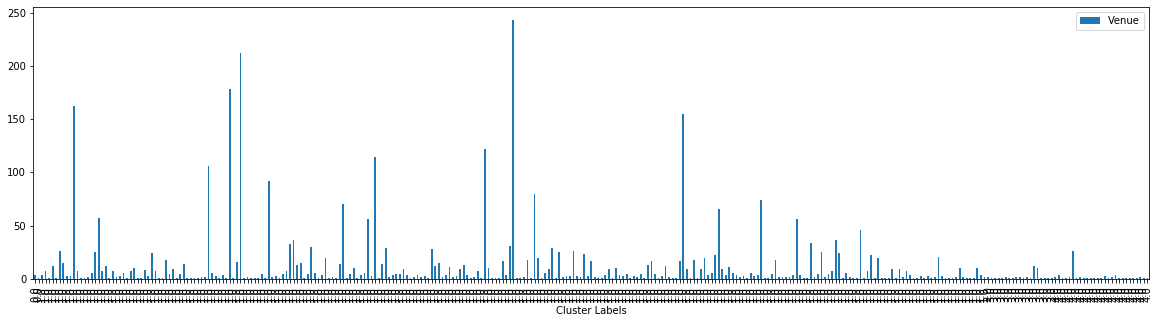

In [215]:
#result_merged.groupby(['Cluster Labels'])['Venue'].count().reset_index().plot(kind='bar', figsize=(20, 5))
#plt.show()

result_merged_groupby_2 = result_merged.groupby(['Cluster Labels','Venue Category'])['Venue'].count().reset_index()
result_merged_groupby_2.plot('Cluster Labels', kind='bar', figsize=(20, 5))


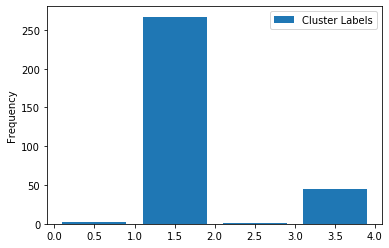

In [189]:
result_merged_groupby_1 = result_merged.groupby(['Cluster Labels','Venue Category'])['Venue'].count().reset_index()
result_merged_groupby_1
result_merged_groupby_1[['Cluster Labels','Venue Category']].plot(kind='hist',bins=[0,1,2,3,4],rwidth=0.8)
plt.show()


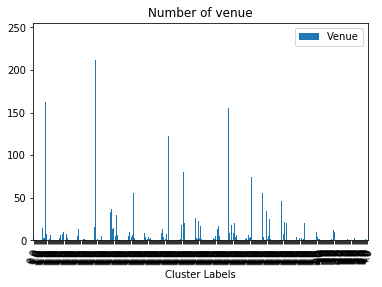

In [224]:
result_merged_groupby_4 = result_merged.groupby(['Cluster Labels','Venue Category'])['Venue'].count().reset_index()
result_merged_groupby_4.head()
#result_merged_groupby_4.plot('Cluster Labels',['Venue'], kind = 'bar', figsize=(20, 5))
#result_merged_groupby_4.plot.bar()

result_merged_groupby_4.plot.bar(x="Cluster Labels", y="Venue", rot=70, title="Number of venue");
plt.show(block=True);

In [217]:
latitude_jakarta = -6.2658393
longitude_jakarta = 106.7842567
world_geo = r'world_countries.json'
world_map = folium.Map(location=[latitude_jakarta, longitude_jakarta], zoom_start=9)

world_map.choropleth(
    geo_data=world_geo,
    data=result_merged_groupby_4,
    columns=['urban', 'Venue'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venue of Neighboorhoud'
)

# display map
world_map

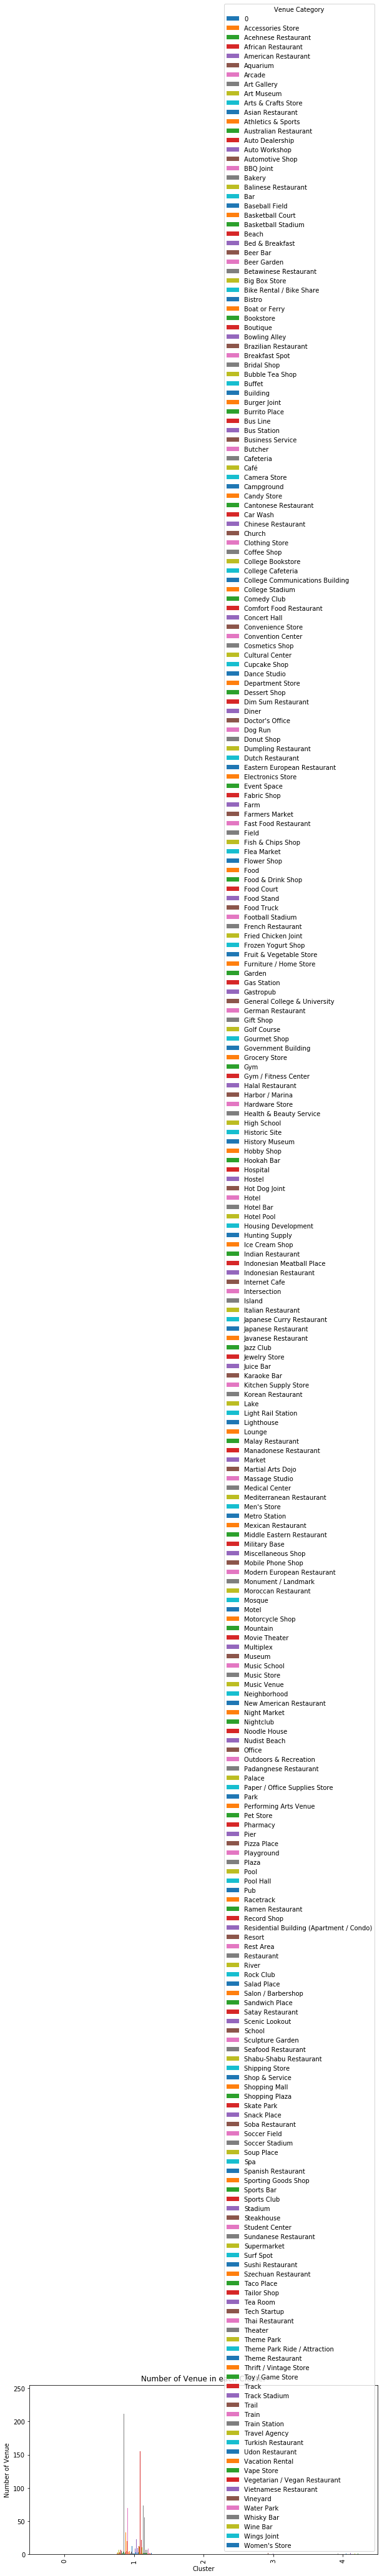

In [94]:
result_merged_final.groupby(['cluster','Venue Category'])['Venue Category'].count().unstack().plot(
    kind='bar', 
    figsize=(10, 5)
)
plt.title('Number of Venue in each Cluster')
plt.ylabel('Number of Venue', fontsize=10)
plt.xlabel('Cluster', fontsize=10)
#plt.xticks(15)
#plt.legend(bbbox_to_anchor=(1,0,5))

plt.show()

visualize the resulting clusters

In [263]:
import math

# create map
map_clusters = folium.Map(location=[latitude_jakarta, longitude_jakarta], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
#jakarta_merged['Cluster Labels'] = jakarta_merged['Cluster Labels'].astype(int)
for lat, lon, poi, cluster in zip(
    jakarta_merged['latitude'], 
    jakarta_merged['longitude'], 
    jakarta_merged['urban'], 
    jakarta_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    if np.isnan(cluster - 1):
        n_int = 0
    else:
        n_int = int((cluster - 1))
    #print (n_int)   
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[n_int],
        #color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[n_int],
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Examine Clusters</h2>

<h3>cluster 1</h3>

In [96]:
jakarta_merged.loc[
    jakarta_merged['Cluster Labels'] == 0, 
    jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,CAKUNG,"CAKUNG BARAT, ID 13910",-6.1724,106.9344,0.0,Asian Restaurant,Women's Store,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court,Farmers Market
81,MAKASAR,"MAKASAR, ID 13570",-6.2764,106.8773,0.0,Market,Asian Restaurant,Women's Store,Farmers Market,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop
134,CIPAYUNG,"SETU, ID 13880",-6.3117,106.9153,0.0,Asian Restaurant,Women's Store,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court,Farmers Market
137,CILINCING,"SUKAPURA, ID 14140",-6.1475,106.9279,0.0,Asian Restaurant,Women's Store,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Court,Farmers Market


<h3>cluster 2</h3>  

In [97]:
jakarta_merged.loc[
    jakarta_merged['Cluster Labels'] == 1, 
    jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PADEMANGAN,"ANCOL, ID 14430",-6.126400,106.829100,1.0,Theme Park Ride / Attraction,Theme Park,Hotel,Playground,Sundanese Restaurant,Seafood Restaurant,Harbor / Marina,Japanese Restaurant,Athletics & Sports,Javanese Restaurant
1,TAMBORA,"ANGKE, ID 11330",-6.145900,106.795900,1.0,Noodle House,Lounge,Café,Juice Bar,Snack Place,Indonesian Restaurant,Thrift / Vintage Store,Food Truck,Food Stand,Food Court
2,KRAMAT JATI,"BALEKAMBANG, ID 13530",-6.281400,106.852400,1.0,Fast Food Restaurant,Gym,Restaurant,Food Court,Women's Store,Flower Shop,Field,Fish & Chips Shop,Flea Market,Food & Drink Shop
3,MAMPANG PRAPATAN,"BANGKA, ID 12730",-6.265400,106.818600,1.0,Café,Coffee Shop,Bar,Wine Bar,Lounge,Restaurant,Camera Store,Bookstore,Beach,Gym / Fitness Center
6,TANAH ABANG,"BENDUNGAN HILIR, ID 10210",-6.208700,106.808800,1.0,Indonesian Restaurant,Convenience Store,Food Truck,Soup Place,Pizza Place,Spa,Acehnese Restaurant,Hotel,Coffee Shop,Residential Building (Apartment / Condo)
7,JATINEGARA,"BIDARACINA, ID 13330",-6.235700,106.868100,1.0,Indonesian Meatball Place,Pharmacy,Fast Food Restaurant,Café,Salon / Barbershop,Gas Station,Multiplex,College Stadium,Hotel,Convenience Store
8,PESANGGRAHAN,"BINTARO, ID 12330",-6.270400,106.765300,1.0,Food Truck,Asian Restaurant,Motorcycle Shop,Pizza Place,Convenience Store,Restaurant,Bakery,Clothing Store,Coffee Shop,Flower Shop
9,SENEN,"BUNGUR, ID 10460",-6.171700,106.847700,1.0,Fabric Shop,Cupcake Shop,French Restaurant,Hotel,Train Station,Food,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market
11,CAKUNG,"CAKUNG TIMUR, ID 13910",-6.173200,106.953600,1.0,Theme Park,Coffee Shop,Food Court,Indonesian Restaurant,Burger Joint,Bakery,Shopping Mall,Multiplex,Supermarket,Department Store
12,KRAMAT JATI,"CAWANG, ID 13630",-6.250700,106.868500,1.0,Indonesian Restaurant,Noodle House,Fast Food Restaurant,Restaurant,Food,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop


<h3>cluster 3</h3>

In [98]:
jakarta_merged.loc[
    jakarta_merged['Cluster Labels'] == 2, 
    jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
230,KEPULAUAN SERIBU UTARA,"PULAU HARAPAN, ID 14540",-5.501671,106.549568,2.0,Nudist Beach,Women's Store,Farmers Market,Fried Chicken Joint,French Restaurant,Football Stadium,Food Truck,Food Stand,Food Court,Food & Drink Shop
231,KEPULAUAN SERIBU UTARA,"PULAU KELAPA, ID 14540",-5.501671,106.549568,2.0,Nudist Beach,Women's Store,Farmers Market,Fried Chicken Joint,French Restaurant,Football Stadium,Food Truck,Food Stand,Food Court,Food & Drink Shop


<h3>cluster 4</h3>

In [99]:
jakarta_merged.loc[
    jakarta_merged['Cluster Labels'] == 3, 
    jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,PASAR REBO,"BARU, ID 13780",-6.324100,106.846600,3.0,Pizza Place,Indonesian Restaurant,Cafeteria,Noodle House,Food Truck,Food Stand,Food Court,Football Stadium,Farmers Market,Food
5,KRAMAT JATI,"BATUAMPAR, ID 13520",-6.278100,106.861500,3.0,Pub,Pizza Place,Women's Store,Food & Drink Shop,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food
24,CIPAYUNG,"CIPAYUNG, ID 13840",-6.330400,106.893400,3.0,Wings Joint,Pizza Place,Noodle House,Bar,Football Stadium,Food Truck,French Restaurant,Food Stand,Fried Chicken Joint,Food & Drink Shop
71,PALMERAH,"KEMANGGISAN, ID 11480",-6.189800,106.791100,3.0,Noodle House,Bridal Shop,Medical Center,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Women's Store
98,KELAPA GADING,"PEGANGSAAN DUA, ID 14250",-6.160600,106.914600,3.0,Noodle House,Women's Store,Farmers Market,Fried Chicken Joint,French Restaurant,Football Stadium,Food Truck,Food Stand,Food Court,Food & Drink Shop
132,KEMAYORAN,"SERDANG, ID 10650",-6.159100,106.861000,3.0,Noodle House,Women's Store,Farmers Market,Fried Chicken Joint,French Restaurant,Football Stadium,Food Truck,Food Stand,Food Court,Food & Drink Shop
140,TAMBORA,"TAMBORA, ID 11220",-6.145100,106.808900,3.0,Noodle House,Food Truck,Chinese Restaurant,Asian Restaurant,School,Vegetarian / Vegan Restaurant,Flea Market,Farmers Market,Fast Food Restaurant,Field
185,MATRAMAN,"KAYU MANIS, ID 13130",-6.202623,106.862827,3.0,Pizza Place,Convenience Store,Women's Store,Food & Drink Shop,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food
262,MATRAMAN,"UTAN KAYU SELATAN, ID 13120",-6.197987,106.867990,3.0,Pizza Place,Food Court,Market,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Women's Store
263,MATRAMAN,"UTAN KAYU UTARA, ID 13120",-6.197987,106.867990,3.0,Pizza Place,Food Court,Market,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Women's Store


<h3>cluster 5</h3>

In [100]:
jakarta_merged.loc[
    jakarta_merged['Cluster Labels'] == 4, 
    jakarta_merged.columns[[1] + list(range(5, jakarta_merged.shape[1]))]
]

,sub_district,address,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,JAGAKARSA,"CIGANJUR, ID 12630",-6.335600,106.807500,4.0,Convenience Store,Women's Store,Food Court,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand
45,KEBAYORAN LAMA,"GROGOL UTARA, ID 12210",-6.216400,106.787100,4.0,Convenience Store,Women's Store,Food Court,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand
56,JOHAR BARU,"JOHAR BARU, ID 10560",-6.185900,106.857200,4.0,Convenience Store,Government Building,Arcade,Fast Food Restaurant,Women's Store,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop
60,KRAMAT JATI,"KAMPUNG TENGAH, ID 13540",-6.290400,106.865700,4.0,Breakfast Spot,Convenience Store,Spa,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food Stand
61,CENGKARENG,"KAPUK, ID 11720",-6.140900,106.750100,4.0,Convenience Store,Women's Store,Food Court,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand
108,PESANGGRAHAN,"PESANGGRAHAN, ID 12320",-6.255100,106.758600,4.0,Convenience Store,Arcade,Food Truck,Women's Store,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food
123,CIRACAS,"RAMBUTAN, ID 13830",-6.306600,106.877300,4.0,Convenience Store,Pizza Place,Women's Store,Food & Drink Shop,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food
139,CIRACAS,"SUSUKAN, ID 13750",-6.311600,106.869900,4.0,BBQ Joint,Convenience Store,Supermarket,Women's Store,Food & Drink Shop,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food
156,CILINCING,"CILINCING, ID 14120",-6.106328,106.941763,4.0,Convenience Store,Women's Store,Food Court,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand
174,KALIDERES,"KALIDERES, ID 11840",-6.152256,106.702825,4.0,Seafood Restaurant,Convenience Store,Supermarket,Asian Restaurant,Food & Drink Shop,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop
